In [1]:
%%time

import nibabel as nib
import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
%matplotlib inline

import dmipy.data.saved_acquisition_schemes as saved_acquisition_schemes

from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
from dmipy.core.fitted_modeling_framework import FittedMultiCompartmentModel

from dipy.viz import window, actor

import tqdm

import warnings
warnings.filterwarnings("ignore")
import numba
import pathos

Wall time: 1.97 s


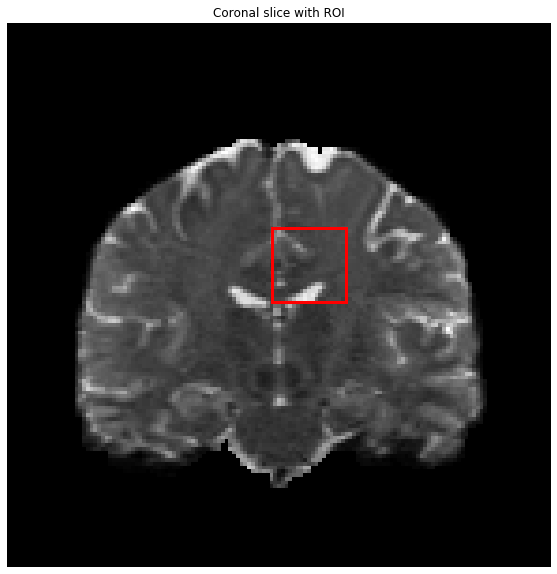

In [2]:
data_hcp = nib.load('wu_minn_hcp_coronal_slice.nii.gz').get_data()
scheme_hcp = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

roi = {'x': 70, 'y': 70, 'width': 20, 'height': 20}
data_hcp_roi = data_hcp[
    roi['x'] : roi['x'] + roi['width'], :, roi['y'] : roi['y'] + roi['height']
]

fig, ax = plt.subplots(figsize=[10, 10])
ax.imshow(data_hcp[:, 0, :, 0].T, origin='lower', cmap='gray', interpolation='nearest')

rect = patches.Rectangle(
    (roi['x'], roi['y']), roi['width'], roi['height'], 
    linewidth = 3, edgecolor = 'r', facecolor = 'none'
)
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('Coronal slice with ROI');

In [3]:
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

In [4]:
def set_parameters(our_voxel_bas_model, scheme_hcp, voxel_signal):
    params = []

    # estimate S0
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    # G1Ball_1_lambda_iso
    param_range = our_voxel_bas_model.parameter_ranges['G1Ball_1_lambda_iso']
    lambda_iso = np.random.uniform(param_range[0], param_range[1]) * 1e-09

    # C1Stick_1_mu
    param_ranges = our_voxel_bas_model.parameter_ranges['C1Stick_1_mu']
    mu_1 = np.random.uniform(param_ranges[0][0], param_ranges[0][1])
    mu_2 = np.random.uniform(param_ranges[1][0], param_ranges[1][1])
    
    # C1Stick_1_lambda_par
    param_range = our_voxel_bas_model.parameter_ranges['C1Stick_1_lambda_par']
    lambda_parallel = np.random.uniform(param_range[0], param_range[1]) * 1e-09
    
    # partial_volume_0
    param_range = our_voxel_bas_model.parameter_ranges['partial_volume_0']
    f_stick = np.random.uniform(param_range[0], param_range[1])
    
    # partial_volume_1
    param_range = our_voxel_bas_model.parameter_ranges['partial_volume_1']
    f_ball = np.random.uniform(param_range[0], param_range[1])
            
    return FittedMultiCompartmentModel(
        our_voxel_bas_model, np.array(S0), np.array([True]), 
        np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in range(roi['width']):
    our_bas_model[x] = {}
    for y in range(roi['height']):
        
        voxel_signal = data_hcp_roi[x, 0, y, :]
        our_bas_model[x][y] = set_parameters(bas_model, scheme_hcp, voxel_signal)
        
        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)
          
print("Fitting accuracy:")        
print("MSE +/- STD = %f +/- %f" % (np.mean(voxel_mse), np.std(voxel_mse)))

Fitting accuracy:
MSE +/- STD = 0.098870 +/- 0.108786


our randomized model:


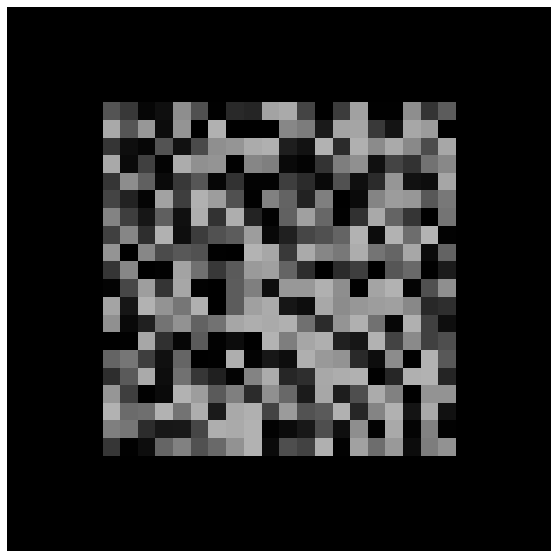

In [5]:
def visualize_result(bas_models_fit):

    affine = np.eye(4)
    affine[0,3] = -10
    affine[1,3] = -10

    volume = np.zeros([roi['width'], roi['height'], 1])
    peak_dirs = np.zeros([roi['width'], roi['height'], 1, 1, 3])

    for x in range(roi['width']):
        for y in range(roi['height']):
            volume[x, y, 0] = bas_models_fit[x][y].fitted_parameters['partial_volume_0']
            peak_cart = np.squeeze(bas_models_fit[x][y].peaks_cartesian())
            peak_dirs[x, y, 0] = [peak_cart[0], peak_cart[2], -peak_cart[1]]

    ren = window.ren()
    ren.add(actor.slicer(volume, interpolation='nearest', affine=affine, opacity=0.7))
    ren.add(actor.peak_slicer(peak_dirs, None, affine=affine, linewidth=5, colors=None))   

    window.record(ren, size=[700, 700], out_path='dipy.png')
    
    img = mpimg.imread('dipy.png')
    plt.figure(figsize=[10, 10])
    plt.imshow(img) #[100:-97, 100:-85])
    plt.axis('off');
    
print("our randomized model:")
visualize_result(our_bas_model)

In [6]:
def set_params_from_chrom(chrom, our_voxel_bas_model, scheme_hcp, voxel_signal):
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    mu_1, mu_2 = chrom[0], chrom[1]
    lambda_parallel = chrom[2] * 1e-09
    lambda_iso = chrom[3] * 1e-09
    f_stick = chrom[4]
    f_ball = chrom[5]
    
    return FittedMultiCompartmentModel(
            our_voxel_bas_model, np.array(S0), np.array([True]), 
            np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )


def single_voxel_function(chromosome, bas_model, scheme_hcp, voxel_signal):
    '''
    dla danego chromosomu o dl. 6 wypluwa jego MSE
    '''
    model = set_params_from_chrom(chromosome, bas_model, scheme_hcp, voxel_signal)
    return model.mean_squared_error(voxel_signal)

def domain_dict_to_array(d):
    domains_dict = d
    domains_list = np.array(list(domains_dict.values()))
    domains_array = np.array(domains_list[0][0])
    domains_array = np.vstack((domains_array, domains_list[0][1]))
    domains_array = np.vstack((domains_array, domains_list[1]))
    domains_array = np.vstack((domains_array, domains_list[2]))
    domains_array = np.vstack((domains_array, domains_list[3]))
    domains_array = np.vstack((domains_array, domains_list[4]))
    return domains_array


In [9]:
class ES():
    def __init__(self, R, d, mi, lambda_, F, max_iter=100,learning_rate=0.01,debug=False, ES_type="+",mutation_type="0"):
        self.R = R
        self.d = d
        self.mi = mi # offspring
        self.lambda_ = lambda_ # parents
        self.F = F
        self.current_population = []
        self.current_values = []
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tau0 = learning_rate/np.sqrt(2*np.sqrt(d))
        self.tau = learning_rate/np.sqrt(2*d)
        self.debug = debug
        self.sigma = 0.25
        
        if mutation_type == "0":
            self.mutation = self.mutation0
        if mutation_type == "1":
            self.mutation = self.mutation1
        if mutation_type == "2":
            self.mutation = self.mutation2
        if mutation_type == "3":
            self.mutation = self.mutation3
        if mutation_type == "4":
            self.mutation = self.mutation4
        
        if ES_type == "+":
            self.es_type = '+'
        elif ES_type == ",":
            self.es_type = ','
        else:
            print("Wrong ES type. Try '+' or ','")
        
        self.results = np.array([(0,0,0)])
    
    def in_domain(self, chrom):
        for p in range(len(chrom)):
            if not self.R[p][0] < chrom[p] < self.R[p][1]:
                chrom[p] = np.random.uniform(self.R[p][0],self.R[p][1])
        return chrom
        
    def check_if_in_domain(self, chrom):
        for p in range(len(chrom)):
            if not self.R[p][0] < chrom[p] < self.R[p][1]:
                return False
        return True
    
    def plot_values(self):
        plt.figure()
        plt.plot(self.results.T[1].T,color='green',label='min')
        plt.plot(self.results.T[0].T,color='blue',label='mean')
        plt.plot(self.results.T[2].T,color='red',label='max')
        plt.legend()
        plt.show()
        
    def random_population(self):
        # arg: self.mi
        # osobnik: x1,...,xd, s1,...,sd
        self.current_population = np.zeros((self.mi, 2, self.d))
        for pop in range(self.mi):
            for p in range(self.d):
                self.current_population[pop][0][p] = np.random.uniform(self.R[p][0],self.R[p][1])
                self.current_population[pop][1][p] = np.random.uniform(self.R[p][0],self.R[p][1])
        self.current_values = np.zeros((self.mi, 1))
    
    def population_evaluation(self):
        self.previous_cost = np.mean(self.current_values)
        better_counter = 0
        for i,sb in enumerate(self.current_population):
            self.current_values[i] = self.F(sb[0])
            if self.current_values[i] > self.previous_cost:
                better_counter += 1
#         if better_counter > 1/5*len(self.current_values):
#             self.learning_rate = self.learning_rate * (better_counter/len(self.current_values) + 1 )
#         else:
#             self.learning_rate *= 0.95
        self.learning_rate *= np.exp(1/3 * (better_counter/len(self.current_values) - 0.2)/(1 - 0.2))
        self.tau0 = self.learning_rate/np.sqrt(2*np.sqrt(self.d))
        self.tau = self.learning_rate/np.sqrt(2*self.d)
    
    def parent_selection(self):
        # arg: self.current_population, self.lambda_
        
        # roulette method
        costs = np.array([self.F(i[0]) for i in self.current_population])
        costs = costs.reshape(-1)
        fitness_values = costs - costs.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / self.mi * np.ones(self.mi)
        parent_indices = np.random.choice(len(self.current_population), size=len(self.current_population), replace=True,p=fitness_values).astype(np.int64)
        return self.current_population[parent_indices]
    
    def mutation0(self, pc):
        # sprawdz czy miesci sie w dziedzinie
        pcc = pc.copy()
        for sb in range(len(pc)):
            addition = np.exp(np.random.normal(0, self.tau ** 2, size=len(pc[sb][1])) + np.random.normal(0, self.tau0 ** 2))
            # taus
            pcc[sb][1] *= addition
            los = pcc[sb][0] + np.random.normal(0, pcc[sb][1] ** 2,size=self.d)
            # jesli ciagle poza dziedzina
            los = self.in_domain(los)
            pcc[sb][0] = los
        return pcc
    
    def mutation1(self, pc):
        for sb in range(len(pc)):
            sigma = 0.25
            pc[sb][0] += sigma * np.random.randn(self.d)
            pc[sb][0] = self.in_domain(pc[sb][0])
        return pc
    
    def mutation2(self, pc):
        sigma = 0.25
        S = np.random.uniform(0, sigma, self.d)
        for sb in range(len(pc)):
            pc[sb][0] += S * np.random.randn(self.d)
            pc[sb][0] = self.in_domain(pc[sb][0])
        return pc
    
    def mutation3(self, pc):
        sigma = 0.25
        S = np.random.uniform(0,sigma, size=(self.d, self.d))
        S = np.dot(S,S.T)
        b = np.dot(np.random.randn(self.mi, self.d), np.linalg.cholesky(S).T)
        
        for sb in range(len(pc)):
            pc[sb][0] += b[sb]
            pc[sb][0] = self.in_domain(pc[sb][0])
        return pc
    
    def mutation4(self, pc):
        # sprawdz czy miesci sie w dziedzinie
        pcc = pc.copy()
        for sb in range(len(pc)):
            addition = np.exp(np.random.normal(0, self.tau ** 2, size=len(pc[sb][1])) + np.random.normal(0, self.tau0 ** 2))
            # taus
            pcc[sb][1] *= addition
            
            los = pcc[sb][0] + np.random.normal(0, pcc[sb][1] ** 2,size=self.d)
            for _ in range(3):
                if self.check_if_in_domain(los):
                    break
                los = pcc[sb][0] + np.random.normal(0, pcc[sb][1] ** 2,size=self.d)
                
            # jesli ciagle poza dziedzina
            los = self.in_domain(los)
            pcc[sb][0] = los
        return pcc
    
    def replacement(self, pc):
        # tu bedziemy zmieniac self.current_population
        if self.es_type == ",":
            random_indices = np.random.choice(np.arange(0, len(pc)), size=len(self.current_population))
            self.current_population[random_indices] = pc[random_indices]
                
        elif self.es_type == "+":
            # wybierzmy najlepszych
            all_values = np.append(self.current_values, np.array([self.F(i[0]) for i in pc]))
            all_individuals = np.vstack((self.current_population, pc))
            best_pop_id = np.argsort(all_values)
            self.current_population = all_individuals[best_pop_id[:len(self.current_population)]]
        
    def run(self):
        self.random_population()
        self.population_evaluation()
        
        for i in range(self.max_iter):
            pc = self.parent_selection()
            pc = self.mutation(pc)
            self.replacement(pc)
            self.population_evaluation()
            self.results = np.vstack((self.results, (self.current_values.mean(), self.current_values.min(),self.current_values.max())))
            if self.debug and i%int(self.max_iter/10) == 0:
                print(self.current_values.mean(), self.current_values.min(),self.current_values.max())
        # tu zwrocic najlepszego osobnika z populacji
        self.results = self.results[1:]
        return self.current_population[np.argmin(self.current_values)]

In [8]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 15
T = 120

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type="+",mutation_type="2")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:51<00:00, 14.58s/it]


Final MSE: 0.003490237288506085 and STD: 0.0017751858741999961
Wall time: 4min 51s


In [9]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 15
T = 50

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type="+",mutation_type="0")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:19<00:00,  6.96s/it]


Final MSE: 0.0058354066213785515 and STD: 0.0037648903947990905
Wall time: 2min 19s


In [11]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 15
T = 50

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type="+",mutation_type="0")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:22<00:00,  7.14s/it]


Final MSE: 0.0054194278903875225 and STD: 0.0030535775482156335
Wall time: 2min 22s


In [12]:
class ES_plus():
    def __init__(self, R, d, N, mi, lambda_, F, max_iter=100,learning_rate=0.01,mutation_type="0"):
        self.R = R
        self.d = d
        self.mi = mi # offspring
        self.lambda_ = lambda_ # parents
        self.N = N
        self.F = F
        self.current_population = []
        self.current_values = []
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tau0 = learning_rate/np.sqrt(2*np.sqrt(d))
        self.tau = learning_rate/np.sqrt(2*d)
        self.sigma = 0.25
        
        self.mutation = self.mutation0
        
        self.results = np.array([(0,0,0)])
    
    def in_domain(self, chrom):
        for p in range(len(chrom)):
            if not self.R[p][0] < chrom[p] < self.R[p][1]:
                chrom[p] = np.random.uniform(self.R[p][0],self.R[p][1])
        return chrom
        
    def check_if_in_domain(self, chrom):
        for p in range(len(chrom)):
            if not self.R[p][0] < chrom[p] < self.R[p][1]:
                return False
        return True
        
    def random_population(self):
        # arg: self.mi
        # osobnik: x1,...,xd, s1,...,sd
        self.current_population = np.zeros((self.mi, 2, self.d))
        for pop in range(self.mi):
            for p in range(self.d):
                self.current_population[pop][0][p] = np.random.uniform(self.R[p][0],self.R[p][1])
                self.current_population[pop][1][p] = np.random.uniform(self.R[p][0],self.R[p][1])
        self.current_values = np.zeros((self.mi, 1))
    
    def population_evaluation(self):
        self.previous_cost = np.mean(self.current_values)
        better_counter = 0
        for i,sb in enumerate(self.current_population):
            self.current_values[i] = self.F(sb[0])
            if self.current_values[i] > self.previous_cost:
                better_counter += 1
        self.learning_rate *= np.exp(1/3 * (better_counter/len(self.current_values) - 0.2)/(1 - 0.2))
        self.tau0 = self.learning_rate/np.sqrt(2*np.sqrt(self.d))
        self.tau = self.learning_rate/np.sqrt(2*self.d)
    
    def parent_selection(self):
        # arg: self.current_population, self.lambda_
        
        # roulette method
        costs = np.array([self.F(i[0]) for i in self.current_population])
        costs = costs.reshape(-1)
        fitness_values = costs - costs.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / self.N * np.ones(self.N)
        parent_indices = np.random.choice(self.N, size=(self.mi, self.lambda_), replace=True,p=fitness_values).astype(np.int64)
        return self.current_population[parent_indices]
    
    def mutation0(self, pc):
        # sprawdz czy miesci sie w dziedzinie
        pcc = pc.copy()
        for sb in range(len(pc)):
            addition = np.exp(np.random.normal(0, self.tau ** 2, size=len(pc[sb][1])) + np.random.normal(0, self.tau0 ** 2))
            # taus
            pcc[sb][1] *= addition
            los = pcc[sb][0] + np.random.normal(0, pcc[sb][1] ** 2,size=self.d)
            # jesli ciagle poza dziedzina
            los = self.in_domain(los)
            pcc[sb][0] = los
        return pcc
    
    def replacement(self, pc):
        # wybierzmy najlepszych
        all_values = np.append(self.current_values, np.array([self.F(i[0]) for i in pc]))
        all_individuals = np.vstack((self.current_population, pc))
        best_pop_id = np.argsort(all_values)
        self.current_population = all_individuals[best_pop_id[:len(self.current_population)]]
        
    def run(self):
        self.random_population()
        self.population_evaluation()
        
        for i in range(self.max_iter):
            pc = self.parent_selection()
            pc = self.mutation(pc)
            self.replacement(pc)
            self.population_evaluation()
            self.results = np.vstack((self.results, (self.current_values.mean(), self.current_values.min(),self.current_values.max())))
        # tu zwrocic najlepszego osobnika z populacji
        self.results = self.results[1:]
        return self.current_population[np.argmin(self.current_values)]

In [14]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 15
T = 1

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES_plus(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, N=N,mi=3*N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1)
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


TypeError: object of type 'int' has no len()

In [56]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1, R=None, mutation_type="1"):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))
    
    
    def in_domain(chrom):
        for p in range(len(chrom)):
            if not R[p][0] < chrom[p] < R[p][1]:
                chrom[p] = np.random.uniform(R[p][0],R[p][1])
        return chrom
    
    # possible mutation functions:
    def mut1(og):
        sigma = 0.25
        return og + sigma * np.random.randn(number_of_offspring, chromosome_length)
    
    def mut2(og):
#         sigma = np.array([0.25, 0.5])
        sigma = np.random.uniform(0,1, chromosome_length)
        return og + sigma * np.random.randn(number_of_offspring, chromosome_length)
    
    def mut3(og):
#         S = np.array([[0.25, 0.25],[0.25, 0.5]])
        S = np.random.uniform(0,0.5, size=(chromosome_length, chromosome_length))
        S = np.dot(S,S.T)
        return og + np.dot(np.random.randn(number_of_offspring, chromosome_length), np.linalg.cholesky(S).T)
    
    # mutation function
    if mutation_type == "1":
        mutation_f = mut1
    elif mutation_type == "2":
        mutation_f = mut2
    elif mutation_type == "3":
        mutation_f = mut3
    else:
        print("Wrong mutation function!")

    # generating an initial population
    children_population_objective_values = np.zeros(number_of_offspring)
    current_population_solutions = np.random.rand(population_size, chromosome_length)
    for i in range(population_size):
        current_population_solutions[i] = in_domain(current_population_solutions[i])
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = np.zeros(population_size)
    for p in range(len(current_population_objective_values)):
        current_population_objective_values[p]= objective_function(current_population_solutions[p])

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
#         costs = np.array([self.F(i[0]) for i in self.current_population])
#         costs = costs.reshape(-1)
#         fitness_values = costs - costs.min()
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
#         print(fitness_values)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
#         children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
#         children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)
        children_population_solutions = mutation_f(children_population_solutions)
    
        # checking if in domain
        for j, child in enumerate(current_population_solutions):
            current_population_solutions[j] = in_domain(child)
                        
        # checking if in domain
        for j, child in enumerate(children_population_solutions):
            children_population_solutions[j] = in_domain(child)
        
        # evaluating the objective function on the children population
        for p in range(len(children_population_objective_values)):
            children_population_objective_values[p]= objective_function(children_population_solutions[p])

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(-current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value > current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

In [60]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 15
T = 100

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_objective_value, best_chromosome, _, _, _ = es(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal), 
                    d, N, T, 2*N, 2, 5.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10,
                    R=domain_dict_to_array(bas_model.parameter_ranges))

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:59<00:00,  8.95s/it]


Final MSE: 0.1722669413172509 and STD: 0.055533246003206416
Wall time: 2min 59s


In [61]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 20
T = 200

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_objective_value, best_chromosome, _, _, _ = es(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal), 
                    d, N, T, 2*N, 2, 5.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10,
                    R=domain_dict_to_array(bas_model.parameter_ranges))

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:49<00:00, 23.49s/it]


Final MSE: 0.1722669413172509 and STD: 0.055533246003206416
Wall time: 7min 49s


In [34]:
class ES():
    def __init__(self, R, N, d, mi, lambda_, F, max_iter=100,learning_rate=0.01,debug=False, ES_type="+",mutation_type="0"):
        self.R = R
        self.d = d
        self.N = N
        self.mi = mi # offspring
        self.lambda_ = lambda_ # parents
        self.F = F
        self.current_population = []
        self.current_values = []
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tau0 = learning_rate/np.sqrt(2*np.sqrt(d))
        self.tau = learning_rate/np.sqrt(2*d)
        self.debug = debug
        self.sigma = 0.25
        
        if mutation_type == "0":
            self.mutation = self.mutation0
        if mutation_type == "1":
            self.mutation = self.mutation1
        if mutation_type == "2":
            self.mutation = self.mutation2
        if mutation_type == "3":
            self.mutation = self.mutation3
        if mutation_type == "4":
            self.mutation = self.mutation4
        
        if ES_type == "+":
            self.es_type = '+'
        elif ES_type == ",":
            self.es_type = ','
        else:
            print("Wrong ES type. Try '+' or ','")
        
        self.results = np.array([(0,0,0)])
    
    def in_domain(self, chrom):
        for p in range(len(chrom)):
            if not self.R[p][0] < chrom[p] < self.R[p][1]:
                chrom[p] = np.random.uniform(self.R[p][0],self.R[p][1])
        return chrom
        
    def check_if_in_domain(self, chrom):
        for p in range(len(chrom)):
            if not self.R[p][0] < chrom[p] < self.R[p][1]:
                return False
        return True
    
    def plot_values(self):
        plt.figure()
        plt.plot(self.results.T[1].T,color='green',label='min')
        plt.plot(self.results.T[0].T,color='blue',label='mean')
        plt.plot(self.results.T[2].T,color='red',label='max')
        plt.legend()
        plt.show()
        
    def random_population(self):
        # arg: self.mi
        # osobnik: x1,...,xd, s1,...,sd
        self.current_population = np.zeros((self.N, 2, self.d))
        for pop in range(self.N):
            for p in range(self.d):
                self.current_population[pop][0][p] = np.random.uniform(self.R[p][0],self.R[p][1])
                self.current_population[pop][1][p] = np.random.uniform(self.R[p][0],self.R[p][1])
        self.current_values = np.zeros((self.N, 1))
    
    def population_evaluation(self):
        for i,sb in enumerate(self.current_population):
            self.current_values[i] = self.F(sb[0])
            
            
    def parent_selection(self):
        # roulette method
        costs = self.current_values
        costs = costs.reshape(-1)
        fitness_values = costs - costs.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / self.mi * np.ones(self.mi)
        parent_indices = np.random.choice(self.N, size=(self.mi, self.lambda_), replace=True,p=fitness_values).astype(np.int64)
        children_population = np.zeros((self.mi, 2, self.d))
        
        for i in range(self.mi):
            children_population[i, :] = self.current_population[parent_indices[i, :], :, :].mean(axis=0)
        
        return children_population
    
    def mutation0(self, pc):
        # sprawdz czy miesci sie w dziedzinie
        pcc = pc.copy()
        for sb in range(len(pc)):
            addition = np.exp(np.random.normal(0, self.tau ** 2, size=len(pc[sb][1])) + np.random.normal(0, self.tau0 ** 2))
            # taus
            pcc[sb][1] *= addition
            los = pcc[sb][0] + np.random.normal(0, pcc[sb][1] ** 2,size=self.d)
            # jesli ciagle poza dziedzina
            los = self.in_domain(los)
            pcc[sb][0] = los
        return pcc
    
    def mutation1(self, pc):
        for sb in range(len(pc)):
            sigma = 0.25
            pc[sb][0] += sigma * np.random.randn(self.d)
            pc[sb][0] = self.in_domain(pc[sb][0])
        return pc
    
    def mutation2(self, pc):
        sigma = 0.25
        S = np.random.uniform(0, sigma, self.d)
        for sb in range(len(pc)):
            pc[sb][0] += S * np.random.randn(self.d)
            pc[sb][0] = self.in_domain(pc[sb][0])
        return pc
    
    def mutation3(self, pc):
        sigma = 0.25
        S = np.random.uniform(0,sigma, size=(self.d, self.d))
        S = np.dot(S,S.T)
        b = np.dot(np.random.randn(self.mi, self.d), np.linalg.cholesky(S).T)
        
        for sb in range(len(pc)):
            pc[sb][0] += b[sb]
            pc[sb][0] = self.in_domain(pc[sb][0])
        return pc
    
    def mutation4(self, pc):
        # sprawdz czy miesci sie w dziedzinie
        pcc = pc.copy()
        for sb in range(len(pc)):
            addition = np.exp(np.random.normal(0, self.tau ** 2, size=len(pc[sb][1])) + np.random.normal(0, self.tau0 ** 2))
            # taus
            pcc[sb][1] *= addition
            
            los = pcc[sb][0] + np.random.normal(0, pcc[sb][1] ** 2,size=self.d)
            for _ in range(3):
                if self.check_if_in_domain(los):
                    break
                los = pcc[sb][0] + np.random.normal(0, pcc[sb][1] ** 2,size=self.d)
                
            # jesli ciagle poza dziedzina
            los = self.in_domain(los)
            pcc[sb][0] = los
        return pcc
    
    def replacement(self, pc):
        if self.es_type == ",":
            random_indices = np.random.choice(np.arange(0, len(pc)), size=self.N)
            self.current_population[random_indices] = pc[random_indices]
                
        elif self.es_type == "+":
            all_values = np.append(self.current_values, np.array([self.F(i[0]) for i in pc]))
            all_individuals = np.vstack((self.current_population, pc))
            best_pop_id = np.argsort(all_values)
            self.current_population = all_individuals[best_pop_id[:self.N]]
        
    def run(self):
        self.random_population()
        self.population_evaluation()
        
        for i in range(self.max_iter):
            pc = self.parent_selection()
            pc = self.mutation(pc)
            self.replacement(pc)
            self.population_evaluation()
            self.results = np.vstack((self.results, (self.current_values.mean(), self.current_values.min(),self.current_values.max())))
            if self.debug and i%int(self.max_iter/10) == 0:
                print(self.current_values.mean(), self.current_values.min(),self.current_values.max())
        # tu zwrocic najlepszego osobnika z populacji
        self.results = self.results[1:]
        return self.current_population[np.argmin(self.current_values)]

In [35]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 10
T = 100

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, N=N, mi=N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type="+",mutation_type="2")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:53<00:00,  5.66s/it]


Final MSE: 0.0037886170546203852 and STD: 0.0017890103706440568
Wall time: 1min 53s


In [33]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 10
T = 100

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, N=N, mi=N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type=",",mutation_type="2")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:04<00:00,  3.22s/it]


Final MSE: 0.09670925931867302 and STD: 0.08371964877476513
Wall time: 1min 4s


In [16]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 10
T = 100

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=N, lambda_=4,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type="+",mutation_type="2")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:03<00:00,  6.19s/it]


Final MSE: 0.0038324454884743576 and STD: 0.00194375142152255
Wall time: 2min 3s


In [17]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 10
T = 100

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=N, lambda_=10,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type="+",mutation_type="2")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:04<00:00,  6.23s/it]


Final MSE: 0.0040883059442455285 and STD: 0.002217639978338743
Wall time: 2min 4s


In [18]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 10
T = 100

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=2*N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type="+",mutation_type="2")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:53<00:00, 11.68s/it]


Final MSE: 0.0035854913918714217 and STD: 0.0017702146673381006
Wall time: 3min 53s


In [19]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 10
T = 100

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=10*N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type="+",mutation_type="2")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [17:43<00:00, 53.19s/it]


Final MSE: 0.003318559360157285 and STD: 0.001668170095019291
Wall time: 17min 43s


In [22]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 10
T = 50

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

lambda_ = int(4+np.floor(3*np.log(N)))

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=int(lambda_/2), lambda_=lambda_,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type="+",mutation_type="2")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.51s/it]


Final MSE: 0.006586242288267414 and STD: 0.005069900321733771
Wall time: 30.2 s


In [21]:
# DLA TEJ BYLO NAJLEPIEJ POKI CO 0.0032


%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 20
T = 200

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type="+",mutation_type="2")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:05<00:00, 21.26s/it]


Final MSE: 0.003354595260481712 and STD: 0.001744305099819077
Wall time: 7min 5s


In [23]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 20
T = 50

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

lambda_ = int(4+np.floor(3*np.log(N)))

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=int(lambda_/2), lambda_=lambda_,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type="+",mutation_type="2")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.90s/it]


Final MSE: 0.0063425281920715445 and STD: 0.005553227712390611
Wall time: 38 s


In [26]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 200
T = 200

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

lambda_ = int(4+np.floor(3*np.log(N)))

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=int(lambda_/2), lambda_=lambda_,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type="+",mutation_type="2")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:34<00:00, 10.71s/it]


Final MSE: 0.0038112498110176923 and STD: 0.0023124567927912446
Wall time: 3min 34s
